<div align="right">Python 3.6 Jupyter Notebook</div>

# Network analysis using NetworkX

<div class="alert alert-warning">
<b>This notebook contains advanced exercises that will help you deepen your understanding of Network Analysis.</b> You will be able to achieve 100% for this notebook by successfully completing Exercises 1, 2, 3, 4, 5, 6, and 7.</div>


### Your completion of the notebook exercises will be graded based on your ability to do the following:
 
> **Understand**: Do your pseudo-code and comments show evidence that you recall and understand technical concepts?

> **Apply**: Are you able to execute code (using the supplied examples) that performs the required functionality on supplied or generated data sets? 

> **Analyze**: Are you able to pick the relevant method or library to resolve specific stated questions?

> **Evaluate**: Are you able to interpret the results and justify your interpretation based on the observed data?


#### Notebook objectives
By the end of this notebook, you will be expected to:
> 
  - Prepare a data set for graph analysis, using NetworkX;
  - Evaluate and compare structural properties of a graph object;
  - Interpret what information the structural properties provide in the physical world; and
  - Develop a basic understanding of small-world networks.
  
####  List of exercises:
> **Exercise 1**: Compute the number of call interactions between a pair of nodes.

>**Exercise 2**: Evaluate structure qualitatively in a graph based on visualization.

>**Exercise 3**: Create a graph object using the SMS data set.

>**Exercise 4 [Advanced]**: Compare the centrality structural properties evaluated on a graph.

>**Exercise 5**: Describe the effect on the average clustering coefficient when nodes of lower degree are removed.

>**Exercise 6**: List the two criteria of a small-world network.

>**Exercise 7**: Identify small-world networks, given the values for the characteristic path length and clustering coefficient.

# Notebook introduction 

<img src="./img/social_network_analysis.png" width=350 height=350>

The use of phone logs to infer relationships between volume of communication and other parameters has been an area of major research interest. In his seminal paper,  which was the first application of phone logs, George Kingsley Zipf (1949) investigated the influence of distance on communication. Many studies have since followed. Big data is characterized by significant increases in structured and unstructured data generated by mobile phones that are sampled and captured at high velocities. Its emergence, and the availability of computer processing technologies that are able to store and process these data sets efficiently, has made it possible to expand these studies in order to improve our understanding of human behavior with unprecedented resolution. Mobile phone data allows the inference of real social networks using call detail records, or CDRs (i.e., phone calls, short message service (SMS) and multimedia message (MMS) communications). These records are combined with GPS and WiFi datasets, browsing habits, application logs, and tower data to reveal a superposition of several social actors.

According to Blondel et al. (2015):

> *The mobile nature of a mobile phone brings two advantages: first, the temporal patterns of communications [are] reflected in great detail due to the fact that the owner of the device usually carries the device with them and therefore the possibility of receiving the call exists in almost all cases, and second, the positioning data of a mobile phone allows tracking the displacements of its owner*.

Unlike self-reported surveys – which are often subjective, limited to a very small subset of the population, and have been the only avenue used to gather data in the past – mobile phone CDRs contain information on verifiable communications between millions of people at a time. Further enrichment from geolocation data, which invariably is also collected alongside CDRs, as well as other external data that is available for the target segment (typically demographics), makes mobile phone CDRs an extremely rich and informative source of data for scientists and analysts. 

These interactions via mobile phones can be represented by a large network where nodes represent individuals, and links are drawn between individuals that have had a phone call, or exchanged messages or other media. 

The study of the structure of such networks provides useful insights into their organization, and can assist in improving communication infrastructure, understanding human behavior, traffic planning, and marketing initiatives, among others. According to Gautier Krings (2012), these applications are informed by the extraction and analysis of different kinds of information from large networks, including the following:

1. **Associating every node with geographical coordinates.** This can facilitate how geography influences the creation of links. More specifically, the intensity of communication between nodes decreases as a power of the geographical distance that separates them.

2. **Studying how links in networks change over time (i.e., dynamical networks).** In these networks, new nodes enter or leave the network and the strength of their connections rise and wane during the observation period. Of particular interest is the influence of time scales on the emergence of different structural properties of dynamical networks.

3. **Detecting communities in networks.** Communities are groups of nodes that are densely connected to each other. 



**Load libraries and set global parameters for Matplotlib**

In [2]:
# Load the relevant libraries to your notebook. 
import pandas as pd
import networkx as nx
import matplotlib.pylab as plt 

import numpy as np       
from networkx.drawing.nx_agraph import graphviz_layout
import graphviz
import pygraphviz
import random
from IPython.display import Image, display

# Set global parameters for plotting. 
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

In [3]:
def pydot(G):
    pdot = nx.drawing.nx_pydot.to_pydot(G)
    display(Image(pdot.create_png()))

# 1. Graph structures using NetworkX
In this notebook, you will continue working with the empirical dataset from the "Friends and Family" study used in Module 2. 

### 1.1 Data preparation

As before, the first step is preparing the data for analysis. In the following, you will load the data into a DataFrame object, filter and retain the records of interest, and select the fields or data columns to use when creating graph objects.

#### 1.1.1 Load the data into a DataFrame
In this data, each record or row is typical of what is available in a CDR, i.e., the actors involved, the starting time of the interaction, the duration of the interaction, who initiated it, and who was the recipient, among other details not included here (such as the geolocation of the sender and receiver). 

In [4]:
# Read the CallLog.csv file, print the number of records loaded as well as the first 5 rows.
calls = pd.read_csv('CallLog.csv')
print('Loaded {0} rows of call log.'.format(len(calls)))
calls.head()

Loaded 164905 rows of call log.


participantID.A participantID.B           local_time       type  duration  \
0      sp10-01-02             NaN  2010-08-04 19:11:51  outgoing+       NaN   
1      sp10-01-02             NaN  2010-08-04 18:49:26  outgoing+       NaN   
2      sp10-01-53      sp10-01-04  2010-07-10 19:24:25  outgoing+       NaN   
3      sp10-01-53      sp10-01-04  2010-07-10 19:24:17  outgoing+       NaN   
4      sp10-01-53             NaN  2010-07-15 18:04:23  incoming+       NaN   

                                number.hash  
0   da83375fb3a7631f304a9471add44eeb19d3355  
1   da83375fb3a7631f304a9471add44eeb19d3355  
2  e729a096a6c30c9f523e56329b4cdc7993d83b00  
3  e729a096a6c30c9f523e56329b4cdc7993d83b00  
4  ec5be5bbb1a719fc8c348ebbc577b99a61457575

#### 1.1.2 Row filtering

In the data set, there are calls to outsiders that can be seen in each entry where the participant's ID is "`NaN`". These are not relevant to the current exercise and need to be removed before you proceed. Remove all calls where one of the participant IDs is missing. First, check the number of records in your DataFrame using Pandas's [shape  DataFrame method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html).

In [5]:
# Initial number of records.
calls.shape[0]

164905

Next, review the data using the ``info()`` method.

In [6]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164905 entries, 0 to 164904
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   participantID.A  164905 non-null  object 
 1   participantID.B  60518 non-null   object 
 2   local_time       164905 non-null  object 
 3   type             164904 non-null  object 
 4   duration         59124 non-null   float64
 5   number.hash      164905 non-null  object 
dtypes: float64(1), object(5)
memory usage: 7.5+ MB


Next, you will clean the data by removing interactions involving outsiders as discussed above. Removing missing values is very common in data analysis, and Pandas has a convenient method, appropriately named [dropna()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html), designed to automate this cleaning process.

In [7]:
# Drop rows with NaN in either of the participant ID columns.
calls = calls.dropna(subset = ['participantID.A', 'participantID.B'])
print('{} rows remaining after dropping missing values from selected columns.'.format(len(calls)))
calls.head(n=5)

60518 rows remaining after dropping missing values from selected columns.


participantID.A participantID.B           local_time       type  duration  \
2       sp10-01-53      sp10-01-04  2010-07-10 19:24:25  outgoing+       NaN   
3       sp10-01-53      sp10-01-04  2010-07-10 19:24:17  outgoing+       NaN   
6       sp10-01-53      sp10-01-52  2010-07-20 19:25:54  outgoing+       NaN   
26      sp10-01-01      sp10-01-53  2010-07-23 19:06:01  outgoing+       NaN   
29      sp10-01-01      sp10-01-02  2010-07-23 18:51:17  incoming+       NaN   

                                 number.hash  
2   e729a096a6c30c9f523e56329b4cdc7993d83b00  
3   e729a096a6c30c9f523e56329b4cdc7993d83b00  
6   e22a3263eb0280fa601c400bc87e178a9ac5d3f7  
26  627e38ee55f5373a9bb5133558d623d7b8fe8ff6  
29  6db007cb74cc8537b99e7d230c0452f4ba71d13e

#### 1.1.3 Column selection

For the purpose of this study, you should only focus on the social actors involved in the call interaction. Therefore, you can remove all columns not relevant to the network being analyzed.

In [8]:
# Create a new object containing only the columns of interest.
interactions = calls[['participantID.A', 'participantID.B']]

Finally, exclude rows where the actors are the same.

In [9]:
# Get a list of rows with different participants.
row_with_different_participants = interactions['participantID.A'] != interactions['participantID.B']

# Update "interactions" to contain only the rows identified. 
interactions = interactions.loc[row_with_different_participants,:]
interactions.head()

participantID.A participantID.B
2       sp10-01-53      sp10-01-04
3       sp10-01-53      sp10-01-04
6       sp10-01-53      sp10-01-52
26      sp10-01-01      sp10-01-53
29      sp10-01-01      sp10-01-02

### 1.2 Creating graph objects with NetworkX
The call interactions captured above are directed, meaning that edges (u,v) and (v,u) are different.

First, let's try to capture the number of interactions between social actors, irrespective of who initiated the call. This will be done using an undirected graph. You will need to capture the number of interactions between any pair of actors with a link in the graph. Therefore, the graph object that needs to be created is a weighted undirected graph.

Using a Pandas DataFrame object as direct input into NetworkX to create graphs,  the following demonstration illustrates how to build an unweighted and undirected graph.

In [10]:
# Create an unweighted undirected graph using the NetworkX's from_pandas_edgelist method.
# The column participantID.A is used as the source and participantID.B as the target.
G = nx.from_pandas_edgelist(interactions, 
                             source='participantID.A', 
                             target='participantID.B', 
                             create_using=nx.Graph())

C:\Users\Pathways\AppData\Local\Temp\ipykernel_10192\445249520.py:2: DeprecationWarning: nx.nx_pydot.to_pydot depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  pdot = nx.drawing.nx_pydot.to_pydot(G)


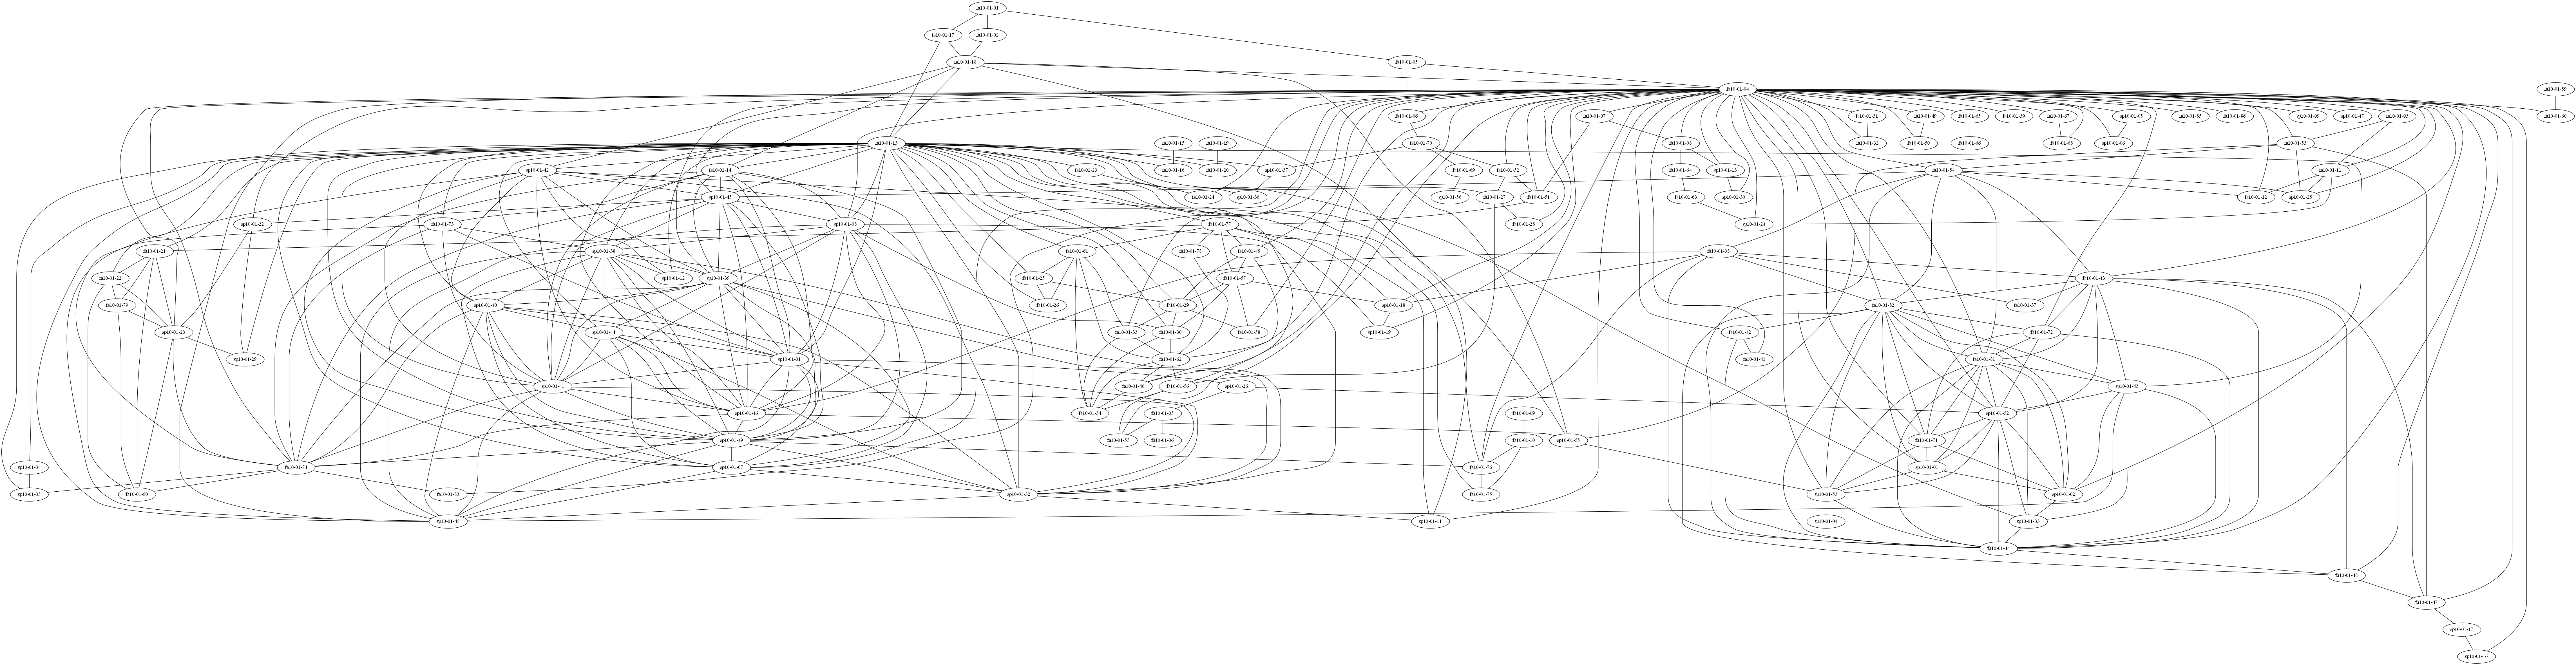

In [26]:
pydot(G)

Review basic information on your graph.

In [11]:
# Print the number of nodes in our network.
print('The undirected graph object G has {0} nodes.'.format(G.number_of_nodes()))

# Print the number of edges in our network.
print('The undirected graph object G has {0} edges.'.format(G.number_of_edges()))

The undirected graph object G has 129 nodes.
The undirected graph object G has 392 edges.


In the following cells, the neighbors for five of the nodes are saved in Python dict, with the node label as key, and then printed.

In [12]:
# Declare a variable for number of nodes to get neighbors of.
max_nodes = 5

In [13]:
# Variable initialization.
count = 0
ndict = {}

# Loop through G and get a node's neigbours, store in ndict. Do this for a maximum of 'max_nodes' nodes. 
for node in list(G.nodes()):
    ndict[node] = tuple(G.neighbors(node))
    count = count + 1
    if count > max_nodes:
        break

In [14]:
print(ndict)

{'sp10-01-53': ('sp10-01-04', 'sp10-01-52', 'sp10-01-01', 'fa10-01-04', 'sp10-01-55', 'fa10-01-81', 'fa10-01-71', 'fa10-01-82', 'fa10-01-44'), 'sp10-01-04': ('sp10-01-53',), 'sp10-01-52': ('sp10-01-53', 'sp10-01-43', 'sp10-01-02', 'sp10-01-01', 'fa10-01-04', 'fa10-01-44', 'fa10-01-82', 'fa10-01-72', 'fa10-01-71', 'sp10-01-33', 'fa10-01-43', 'fa10-01-81', 'sp10-01-26'), 'sp10-01-01': ('sp10-01-53', 'sp10-01-02', 'fa10-01-04', 'sp10-01-52', 'fa10-01-81', 'fa10-01-71', 'fa10-01-82'), 'sp10-01-02': ('sp10-01-01', 'fa10-01-04', 'sp10-01-43', 'sp10-01-52', 'sp10-01-33', 'fa10-01-82', 'fa10-01-81', 'fa10-01-71'), 'sp10-01-08': ('fa10-01-04', 'sp10-01-07', 'sp10-01-38', 'sp10-01-41', 'sp10-01-49', 'sp10-01-31', 'sp10-01-39', 'sp10-01-45', 'fa10-01-30', 'sp10-01-32', 'fa10-01-13', 'fa10-01-14', 'sp10-01-48', 'sp10-01-46')}


In [15]:
# Print only the first item in the dict.
print([list(ndict)[0], ndict[list(ndict)[0]]])

['sp10-01-53', ('sp10-01-04', 'sp10-01-52', 'sp10-01-01', 'fa10-01-04', 'sp10-01-55', 'fa10-01-81', 'fa10-01-71', 'fa10-01-82', 'fa10-01-44')]


Your original objective is to create a **weighted undirected** graph for call interactions, with the weights representing the number of interactions between two distinct participants. As illustrated above, you can use the "from_pandas_dataframe" method to build an undirected graph between the pairs of actors, by specifying the graph structure using a parameter to the argument "create_using=". To get the correct weights in the undirected graph, however, you will need to add the weight information separately. Unfortunately, you cannot rely on NetworkX to do this as it cannot be used to control what data the undirected edges get. Below is a description of how to add the necessary weights to the undirected graph.

The first task is to compute the number of interactions between participants. You will use Pandas' "group_by" DataFrame method to achieve this.

In [16]:
# Get the count of interactions between participants and display the top 5 rows.
grp_interactions = pd.DataFrame(interactions.groupby(['participantID.A', 'participantID.B']).size(), 
                                columns=['counts']).reset_index()

grp_interactions.head(5)

participantID.A participantID.B  counts
0      fa10-01-01      fa10-01-02     870
1      fa10-01-01      fa10-01-05       1
2      fa10-01-01      fa10-01-17       3
3      fa10-01-02      fa10-01-01    1254
4      fa10-01-02      fa10-01-18       2

In [27]:
nx.to_pandas_edgelist?

Signature:
nx.to_pandas_edgelist(
    G,
    source='source',
    target='target',
    nodelist=None,
    dtype=None,
    edge_key=None,
)
Docstring:
Returns the graph edge list as a Pandas DataFrame.

Parameters
----------
G : graph
    The NetworkX graph used to construct the Pandas DataFrame.

source : str or int, optional
    A valid column name (string or integer) for the source nodes (for the
    directed case).

target : str or int, optional
    A valid column name (string or integer) for the target nodes (for the
    directed case).

nodelist : list, optional
   Use only nodes specified in nodelist

dtype : dtype, default None
    Use to create the DataFrame. Data type to force.
    Only a single dtype is allowed. If None, infer.

edge_key : str or int or None, optional (default=None)
    A valid column name (string or integer) for the edge keys (for the
    multigraph case). If None, edge keys are not stored in the DataFrame.

Returns
-------
df : Pandas DataFrame
   Graph edg

Signature:
nx.to_pandas_edgelist(
    G,
    source='source',
    target='target',
    nodelist=None,
    dtype=None,
    edge_key=None,
)
Docstring:
Returns the graph edge list as a Pandas DataFrame.

Parameters
----------
G : graph
    The NetworkX graph used to construct the Pandas DataFrame.

source : str or int, optional
    A valid column name (string or integer) for the source nodes (for the
    directed case).

target : str or int, optional
    A valid column name (string or integer) for the target nodes (for the
    directed case).

nodelist : list, optional
   Use only nodes specified in nodelist

dtype : dtype, default None
    Use to create the DataFrame. Data type to force.
    Only a single dtype is allowed. If None, infer.

edge_key : str or int or None, optional (default=None)
    A valid column name (string or integer) for the edge keys (for the
    multigraph case). If None, edge keys are not stored in the DataFrame.

Returns
-------
df : Pandas DataFrame
   Graph edg

In [18]:
# Create a directed graph with an edge_attribute labeled counts.
g = nx.from_pandas_edgelist(grp_interactions, 
                             source='participantID.A', 
                             target='participantID.B', 
                             edge_attr='counts', 
                             create_using=nx.DiGraph())

Instantiate a weighted undirected graph, and populate edge information using the edges list from the directed graph.

In [19]:
# Set all the weights to 0 at this stage. We will add the correct weight information in the next step.
G = nx.Graph()
G.add_edges_from(g.edges(), counts=0)

Now, iterate through each link from the directed graph, adding the attribute weight (counts) to the corresponding link in the undirected graph.

In [20]:
for u, v, d in g.edges(data=True):
    G[u][v]['counts'] += d['counts']

Look at some of the edges and their corresponding weights.

In [21]:
# Print a sample of the edges, with corresponding attribute data.
max_number_of_edges = 5
count = 0
for n1,n2,attr in G.edges(data=True): # unpacking
    print(n1,n2,attr)
    count = count + 1
    if count > max_number_of_edges:
        break     

fa10-01-01 fa10-01-02 {'counts': 2124}
fa10-01-01 fa10-01-05 {'counts': 2}
fa10-01-01 fa10-01-17 {'counts': 3}
fa10-01-02 fa10-01-18 {'counts': 2}
fa10-01-05 fa10-01-04 {'counts': 122}
fa10-01-05 fa10-01-06 {'counts': 1208}


You can verify whether the steps you executed above have worked using the following:

In [28]:
# Verify our attribute data is correct using a selected (u,v) pair from the data.
u = 'fa10-01-01'
v = 'fa10-01-17'
print('Number of undirected call interactions between {0} and {1} is {2}.'.format(u,
                                                                    v,
                                                            G.get_edge_data(v,u)['counts']))

Number of undirected call interactions between fa10-01-01 and fa10-01-17 is 3.


In [29]:
# Compare our data set to the interactions data set.
is_uv_pair = ((interactions['participantID.A'] == u) & (interactions['participantID.B'] == v)) 
is_vu_pair = ((interactions['participantID.A'] == v) & (interactions['participantID.B'] == u))
print('Number of undirected call interactions between {0} and {1} is {2}'.format(u,
                                            v, 
                                            interactions[is_uv_pair | is_vu_pair].shape[0]))

Number of undirected call interactions between fa10-01-01 and fa10-01-17 is 3


Based on the comparison above, it can be said with confidence that your graph object captures the interactions as expected.

<br>
<div class="alert alert-info">
<b>Exercise 1 Start.</b>
</div>

### Instructions
> Calculate the number of call interactions between participant sp10-01-52 and participant fa10-01-81 captured in your graph, using any of the above approaches.


In [24]:
# Number of call interactions between participant sp10-01-52 and participant fa10-01-81.
u = 'sp10-01-52'
v = 'fa10-01-81'
print('Number of undirected call interactions between {0} and {1} is {2}.'.format(u,
                                                                  v,
                                                            G.get_edge_data(v,u)['counts']))

Number of undirected call interactions between sp10-01-52 and fa10-01-81 is 31.


In [25]:
# Compare our data set to the interactions data set.
is_uv_pair = ((interactions['participantID.A'] == u) & (interactions['participantID.B'] == v)) 
is_vu_pair = ((interactions['participantID.A'] == v) & (interactions['participantID.B'] == u))
print('Number of undirected call interactions between {0} and {1} is {2}'.format(u,
                                            v, 
                                            interactions[is_uv_pair | is_vu_pair].shape[0]))

Number of undirected call interactions between sp10-01-52 and fa10-01-81 is 31


<br>
<div class="alert alert-info">
<b>Exercise 1 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".